# Experiment Notebook: System Metrics

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Sanity Checks](#Analysis-1:-Sanity-Checks)
* [Analysis 2: Correlation Matrix](#Analysis-1:-Correlation-Matrix)
* [Analysis 3: PCV at Risk](#Analysis-3:-PCV-at-Risk)
* [Analysis 4: Capital Allocation Metrics](#Analysis-4:-Capital-Allocation-Metrics)
* [Assorted Metrics](#Analysis-4:-Assorted-Metrics)

# Experiment Summary 

The purpose of this notebook is to demonstrate the system's standard metrics, KPIs and goals.

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 1.07 s (started: 2022-07-08 14:16:34 -04:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 24.9 ms (started: 2022-07-08 14:16:35 -04:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 28.5 ms (started: 2022-07-08 14:16:35 -04:00)


In [4]:
# Inspect experiment template
display_code(default_experiment)

"""
The default experiment with default model Initial State, System Parameters, and Simulation Configuration.
The defaults are defined in their respective modules:
* Initial State in `model/state_variables.py`
* System Parameters in `model/system_parameters.py`
* Simulation Configuration in `experiments/simulation_configuration.py`
"""

from radcad import Simulation, Experiment, Backend

from model import model
from experiments.simulation_configuration import TIMESTEPS, MONTE_CARLO_RUNS
from model.initialization import setup_initial_state, setup_state_update_blocks


# Create Model Simulation
simulation = Simulation(
    model=model,
    timesteps=TIMESTEPS,
    runs=MONTE_CARLO_RUNS
)
# Create Experiment of single Simulation
experiment = Experiment([simulation])
# Configure Simulation & Experiment engine
simulation.engine = experiment.engine
experiment.engine.backend = Backend.SINGLE_PROCESS
experiment.engine.deepcopy = True
experiment.engine.drop_substeps = True

# Configure simulation hooks
before_subset = lambda context: [
    setup_initial_state(context),
    setup_state_update_blocks(context)
]
simulation.before_subset = before_subset
experiment.before_subset = before_subset

time: 122 ms (started: 2022-07-08 14:16:35 -04:00)


In [5]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_2 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_3 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 25.5 ms (started: 2022-07-08 14:16:35 -04:00)


In [6]:
# Experiment configuration
# simulation_1.model.initial_state.update({})
# simulation_1.model.params.update({})

time: 22.2 ms (started: 2022-07-08 14:16:35 -04:00)


# Risk Analysis Methodology

The goal of the FEI Ecosystem Model Risk Analysis is to provide qualitative and quantitative recommendations to surface the most appropriate FEI monetary policy parameter settings across multiple scenarios. The risk analysis includes a cohesive set of model metrics, risk scores and protocol KPIs.

The main holistic risk analysis and parameter recommendation tool at our disposal is the FEI Capital Allocation model, where we allow the model to provide risk-weighted target allocations of FEI in all modeled avenues for FEI liquidity - LP, MM, FSD, Idle. These allocation targets will depend on parameter sweeps of FEI's monetary policy levers such as the FEI Savings Rate (see simplified ERD). The highest scoring parameter settings in terms of FEI Capital allocation and associated comparative KPIs will form the quantitative basis for recommendations.

It is to be noted that we can analyze KPIs comparatively based on monetary policy parameter settings in <b>Two ways</b> - qualitative/deterministic, and statistically based/stochastic.

Since the main driver of volatility in the FEI ecosystem is the Volatile Asset (an abstraction for Ethereum), we can model this volatile asset as Trajectory-based (based on a linear function), or based on a stochastic process such as a Geometric Brownian motion. The application of both settings for the Volatile asset allows us to respectively perform two analysis types.

1. Qualitative recommendations can be made as a result of comparative KPI analysis across different monetary policy parameter settings, using a trajectory model for the Volatile Asset. These do NOT involve monte carlo runs. The output of these analyses is to understand the impact on KPIs as a result of monetary policy changes for various final levels of Volatile Asset price. Ex: For a 30% VA price downturn, Stable backing ratio is higher with monetary policy 1 than policy 2, ie: Delta_1,2 Stable Backing ratio > 0, hence policy 1 is recommended.


2. Statistically-based recommendations can be made as a result of comparative KPI analysis across different monetary policy parameter settings, using a parameterized stochastic model for the Volatile Asset. These DO involve monte carlo runs. The output of these analyses is to construct a probability distribution for each KPI from which summary statistics can be derived. This allows us to empirically say that for a given parameter setting, KPIs are above or below key thresholds with a certain probability. Ex: Over 1000 simulations, 1-Day PCV at Risk is < 1M USD with a 90% probability with policy 1 and < 1M USD with an 85% probability with policy 2. Additionally, the statistical average PCVaR is lower with policy 1 than with policy 2, ie: Delta_1,2 avg. PCVaR > 0. Hence policy 1 is recommended.


# Analysis 1: PCV Sanity Checks

A simulation across 4 volatile asset price scenarios to illustrate PCV state evolution. Here, deterministic price trajectories for the Volatile Asset price are used, as opposed to parameterized stochastic processes.

In [7]:
# Analysis-specific setup
simulation_1.model.params.update({
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 23.8 ms (started: 2022-07-08 14:16:35 -04:00)


In [8]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-07-08 14:16:35,599 - root - INFO - Running experiment
2022-07-08 14:16:35,602 - root - INFO - Setting up initial state
2022-07-08 14:16:35,607 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-08 14:16:36,383 - root - INFO - Setting up initial state
2022-07-08 14:16:36,388 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-08 14:16:37,097 - root - INFO - Setting up initial state
2022-07-08 14:16:37,101 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-07-08 14:16:37,817 - root - INFO - Setting up initial state
2022-07-08 14:16:37,821 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-07-08 14:16:38,524 - root - INFO - Experiment complete in 2.923049211502075 seconds
2022-07-08 14:16:38,524 - root - INFO - Post-processing results
2022-07-08 14:16:40,281 - root - INFO - Post-processing complete in 1.7573058605194092 seconds
time: 4.71 s (started: 2022-07-08 14:16:35 -04:00)


In [9]:
# Post-processing and visualizations

time: 22.7 ms (started: 2022-07-08 14:16:40 -04:00)


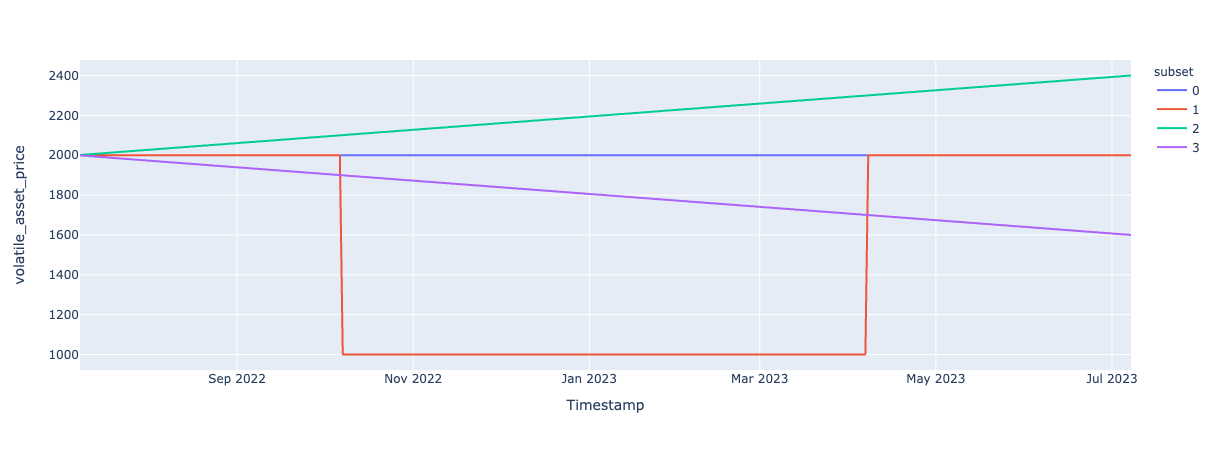

time: 1.09 s (started: 2022-07-08 14:16:40 -04:00)


In [10]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

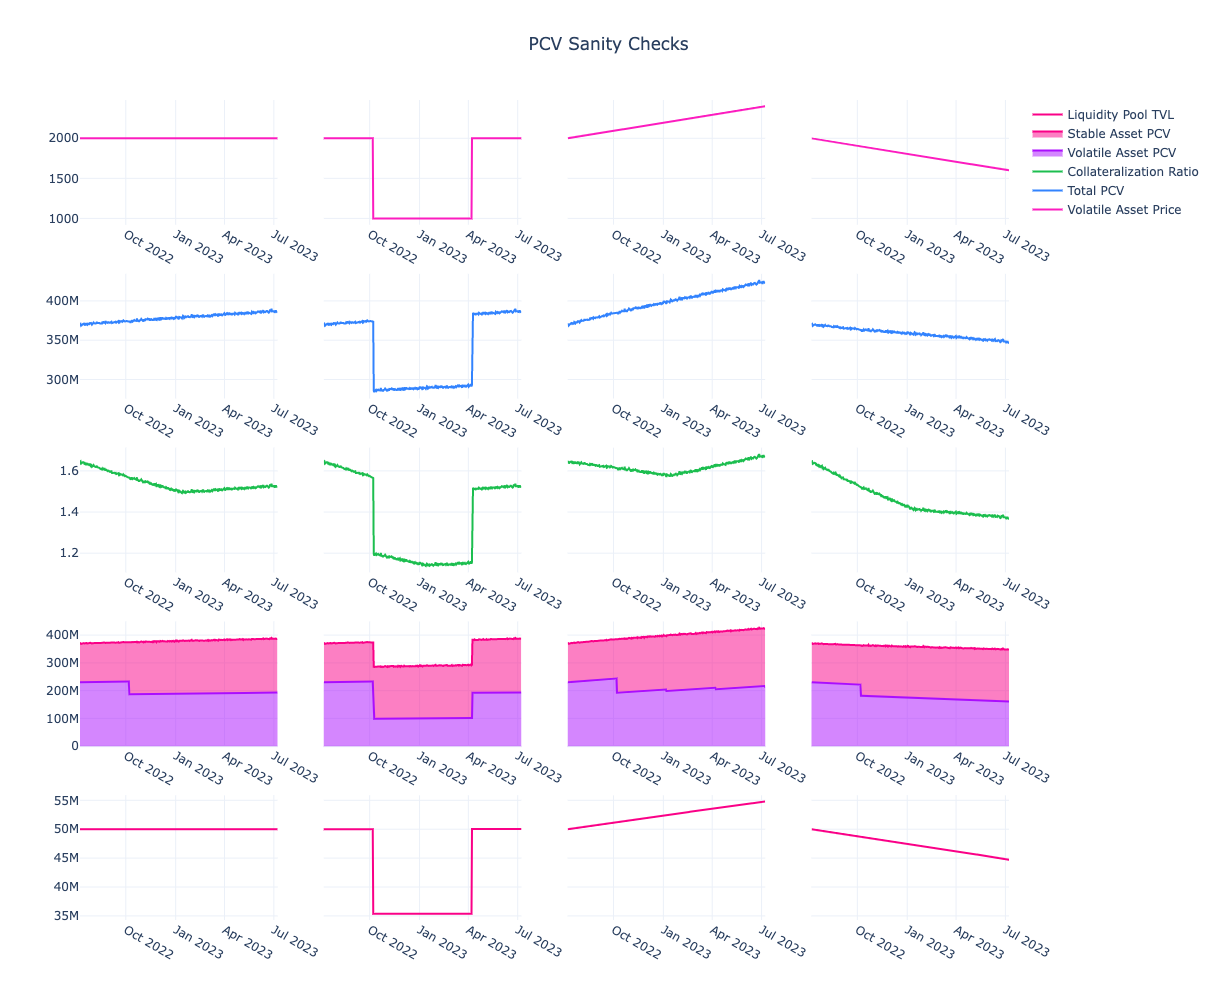

time: 814 ms (started: 2022-07-08 14:16:41 -04:00)


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


fig = make_subplots(rows=5, cols=len(df.subset.unique()), shared_yaxes=True)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[0]),
            showlegend=(True if subset == 0 else False),
        ),
        row=1, col=subset+1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_pcv,
            name="Total PCV",
            line=dict(color=cadlabs_colorway_sequence[1]),
            showlegend=(True if subset == 0 else False),
        ),
        row=2, col=subset+1
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[2]),
            showlegend=(True if subset == 0 else False),
        ),
        row=3, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[3]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
        ),
        row=5, col=subset+1
    )


fig.update_layout(height=1000, title_text="PCV Sanity Checks")
fig.show()

# Analysis 2: Correlation Matrix

In [12]:
# Analysis-specific setup
simulation_2.model.params.update({})

time: 28.6 ms (started: 2022-07-08 14:16:42 -04:00)


In [13]:
# Experiment execution
df_2, exceptions = run(simulation_2)

2022-07-08 14:16:42,312 - root - INFO - Running experiment
2022-07-08 14:16:42,316 - root - INFO - Setting up initial state
2022-07-08 14:16:42,321 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-08 14:16:43,267 - root - INFO - Experiment complete in 0.9511239528656006 seconds
2022-07-08 14:16:43,268 - root - INFO - Post-processing results
2022-07-08 14:16:43,766 - root - INFO - Post-processing complete in 0.4984099864959717 seconds
time: 1.49 s (started: 2022-07-08 14:16:42 -04:00)


In [14]:
# Post-processing and visualizations

time: 29.2 ms (started: 2022-07-08 14:16:43 -04:00)


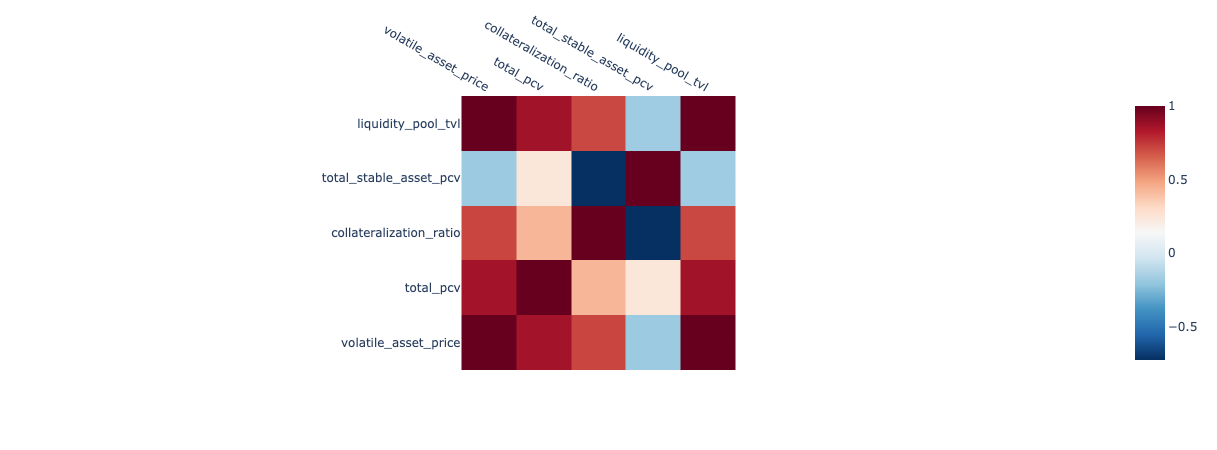

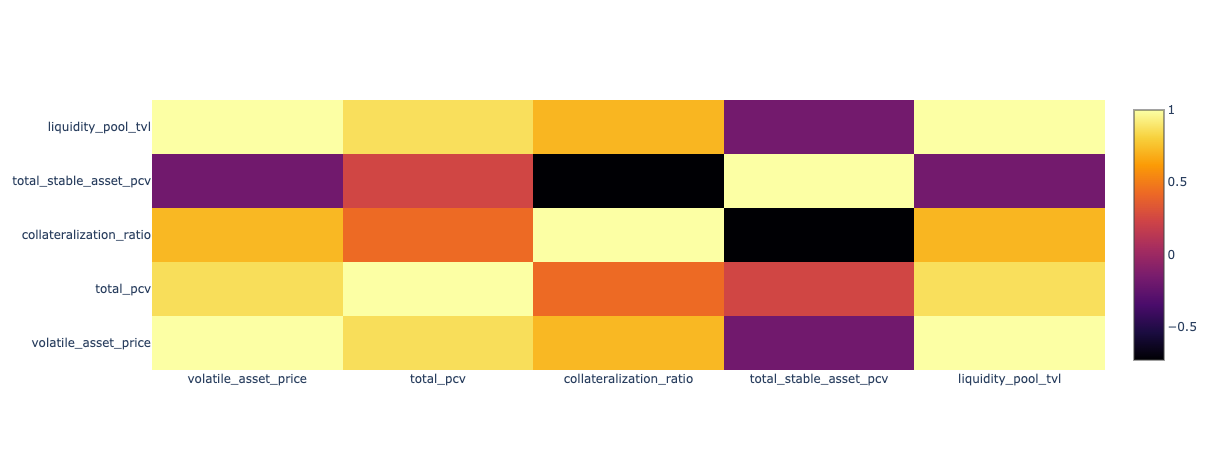

time: 88 ms (started: 2022-07-08 14:16:43 -04:00)


In [15]:
import plotly.graph_objects as go


variables = [
    "volatile_asset_price",
    "total_pcv",
    "collateralization_ratio",
    "total_stable_asset_pcv",
    "liquidity_pool_tvl"
]

z = df_2[variables].corr().values.tolist()

fig = px.imshow(z, x=variables, y=variables, color_continuous_scale='RdBu_r', origin='lower')
fig.update_xaxes(side="top")
fig.show()

fig = go.Figure(data=go.Heatmap(
        z=z,
        x=variables,
        y=variables,
        colorscale='Inferno'
    )
)

fig.show()

# Analysis 3: PCV at Risk

In [16]:
from operator import lt, gt


simulation_3.runs = 10

parameter_overrides = {
    "target_rebalancing_condition": [gt, lt], # Simulate decrease and increase of stable PCV
    "target_stable_pcv_ratio": [0.2, 0.5], # Simulate decrease and increase of stable PCV
    "rebalancing_period": [int(365 / 4)],
}

simulation_3.model.params.update(parameter_overrides)

time: 30 ms (started: 2022-07-08 14:16:43 -04:00)


In [17]:
# Experiment execution
df_3, exceptions = run(simulation_3)

2022-07-08 14:16:43,969 - root - INFO - Running experiment
2022-07-08 14:16:43,971 - root - INFO - Setting up initial state
2022-07-08 14:16:43,975 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-08 14:16:44,833 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-08 14:16:44,837 - root - INFO - Setting up initial state
2022-07-08 14:16:44,842 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-08 14:16:45,714 - root - INFO - Setting up initial state
2022-07-08 14:16:45,719 - root - INFO - Starting simulation 0 / run 1 / subset 0
2022-07-08 14:16:46,602 - root - INFO - Setting up initial state
2022-07-08 14:16:46,606 - root - INFO - Starting simulation 0 / run 1 / subset 1
2022-07-08 14:16:47,452 - root - INFO - Setting up initial state
2022-07-08 14:16:47,456 - root - INFO - Starting simulation 0 / run 2 / subset 0
2022-07-08 14:16:47,884 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-08 14:16:48,112 - root - WARNING - Cashing 

In [18]:
df = df_3

time: 31 ms (started: 2022-07-08 14:17:10 -04:00)


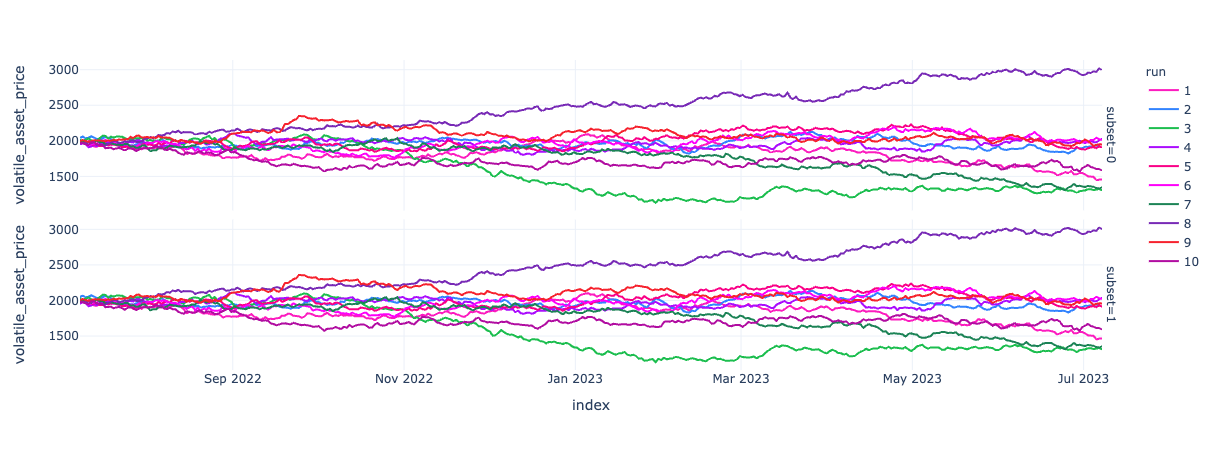

time: 526 ms (started: 2022-07-08 14:17:10 -04:00)


In [19]:
df.plot(y="volatile_asset_price", color="run", facet_row="subset")

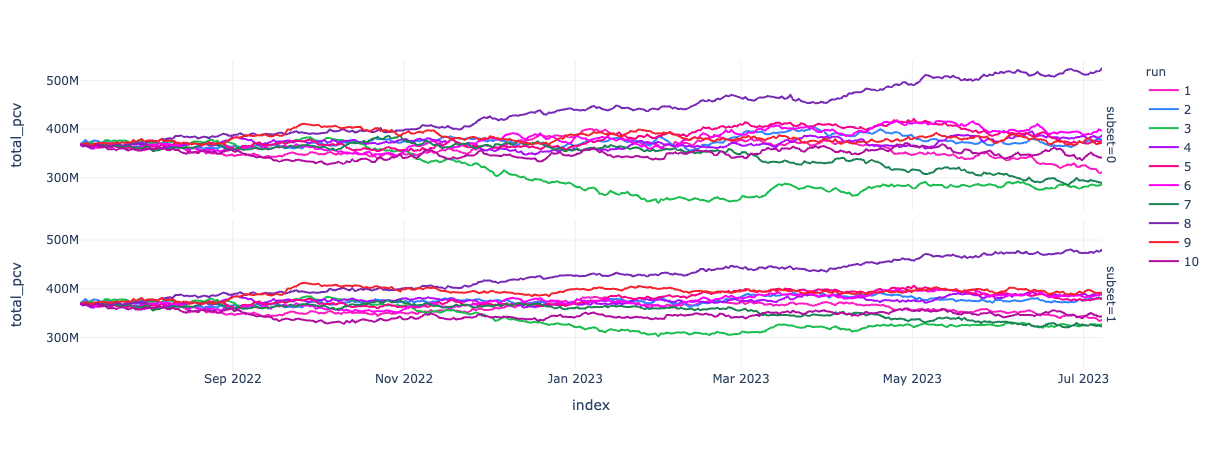

time: 526 ms (started: 2022-07-08 14:17:10 -04:00)


In [20]:
df.plot(y="total_pcv", color="run", facet_row="subset")

## Vectorized PCV at Risk

In this analysis, which is based on a stochastic Volatile Asset Price process with 10 realizations (10 monte carlo runs), we look at two policies (a parameter sweep of size 2) and look at the empirical probability of the PCV at Risk KPI being below a certain threshold, as well as comparatively examine the value of the KPI across both policies to yield a recommendation.

---

### Suggested code refactors, see code comments

In [223]:
import numpy as np


def calculate_VaR(df, state_variable, alpha, timesteps):
    results = pd.DataFrame()

    for simulation in df.simulation.unique():
        df_simulation = df.query("simulation == @simulation")
        for subset in df_simulation.subset.unique():
            df_subset = df_simulation.query("subset == @subset")
            for run in df_subset.run.unique():
                df_run = df_subset.query("run == @run")

                returns = df_run[state_variable].pct_change()
                final_value = df_run[state_variable].iloc[-1]
                q = returns.quantile(1 - alpha)
                value_at_risk = abs(final_value * q) * np.sqrt(timesteps)

                result = pd.DataFrame({'simulation': [simulation], 'subset': [subset], 'run': [run], 'VaR': [value_at_risk], 'q': [q]})
                results = pd.concat([results, result])

    return results.reset_index(drop=True)

time: 32.5 ms (started: 2022-07-08 16:26:47 -04:00)


In [224]:
# TODO How does the alpha used here of 0.95 related to the alpha I've seen used elsewhere of 5? Are we naming this correctly?
# TODO What is q? Can we use a more descriptive variable name?
# NOTE Rather than using timestep start and end as a function argument, let's just pass that dataset into the function
results = calculate_VaR(df, "total_pcv", alpha=0.95, timesteps=1)
results

simulation  subset  run           VaR         q
0            0       0    1  4.147022e+06 -0.013254
1            0       0    2  4.328291e+06 -0.011400
2            0       0    3  4.504893e+06 -0.015664
3            0       0    4  4.618404e+06 -0.011874
4            0       0    5  4.299929e+06 -0.011363
5            0       0    6  4.735048e+06 -0.011914
6            0       0    7  4.346706e+06 -0.014952
7            0       0    8  5.031191e+06 -0.009558
8            0       0    9  4.347827e+06 -0.011642
9            0       0   10  5.223563e+06 -0.015216
10           0       1    1  3.570857e+06 -0.010624
11           0       1    2  3.570308e+06 -0.009388
12           0       1    3  3.383477e+06 -0.010344
13           0       1    4  4.073601e+06 -0.010445
14           0       1    5  3.488449e+06 -0.009198
15           0       1    6  3.519339e+06 -0.009069
16           0       1    7  3.571743e+06 -0.011070
17           0       1    8  3.898569e+06 -0.008111
18           0       1    9  3.567546e+06 -0.009098
19           0       1   10  3.929243e+06 -0.011449

time: 229 ms (started: 2022-07-08 16:26:48 -04:00)


In [225]:
results.query("subset == 0")[["VaR", "q"]].describe()

VaR          q
count  1.000000e+01  10.000000
mean   4.558287e+06  -0.012684
std    3.466965e+05   0.002007
min    4.147022e+06  -0.015664
25%    4.332894e+06  -0.014528
50%    4.426360e+06  -0.011894
75%    4.705887e+06  -0.011460
max    5.223563e+06  -0.009558

time: 46.6 ms (started: 2022-07-08 16:26:48 -04:00)


In [226]:
results.query("subset == 1")[["VaR", "q"]].describe()

VaR          q
count  1.000000e+01  10.000000
mean   3.657313e+06  -0.009880
std    2.256864e+05   0.001058
min    3.383477e+06  -0.011449
25%    3.531391e+06  -0.010579
50%    3.570583e+06  -0.009866
75%    3.816863e+06  -0.009123
max    4.073601e+06  -0.008111

time: 42.8 ms (started: 2022-07-08 16:26:51 -04:00)


In [251]:
quantile_return_threshold = -0.01


def calculate_VaR_threshold_probability(df, threshold):
    results = pd.DataFrame()
    
    for subset in df.subset.unique():
        df_subset = df.query("subset == @subset")
        
        df_threshold = df_subset["q"] <= threshold
        probability = df_threshold.sum() / len(df_threshold)
        
        result = pd.DataFrame({'subset': [subset], 'threshold': [threshold], 'probability': [probability]})
        results = pd.concat([results, result])
    
    return results.reset_index(drop=True)

subset  threshold  probability
0       0      -0.01          0.9
1       1      -0.01          0.5

time: 42.8 ms (started: 2022-07-08 16:34:55 -04:00)


In [255]:
q_probabilities = calculate_VaR_threshold_probability(results, threshold=quantile_return_threshold)

time: 35.6 ms (started: 2022-07-08 16:35:57 -04:00)


In [264]:
for subset in q_probabilities.subset.unique():
    print(f"""For Policy {subset + 1}, the 1-Day PCV at risk is less than 1% with a {int(100*q_probabilities.query('subset == @subset')['probability'])}% probability""")

For Policy 1, the 1-Day PCV at risk is less than 1% with a 90% probability
For Policy 2, the 1-Day PCV at risk is less than 1% with a 50% probability
time: 36.9 ms (started: 2022-07-08 16:39:26 -04:00)


---

In [118]:
def calculate_VaR_run(df, n_run, alpha, n_timesteps, t_start, t_end):
    pcv_ret = df.query('run==@n_run')['total_pcv'].pct_change()
    pcv_final_val = df.query('run==@n_run')['total_pcv'].iloc[-1]
    q = pcv_ret.quantile(1-alpha)
    # see https://www0.gsb.columbia.edu/faculty/pglasserman/B6014/var-d.pdf
    # for n-day var simplifying assumption which allows for generalization
    VaR_n = abs(pcv_final_val * q)*np.sqrt(n_timesteps)
    
    return VaR_n, q

time: 31.4 ms (started: 2022-07-08 15:19:30 -04:00)


In [121]:
def calculate_VaR_subset(df, n_subset, alpha, n_timesteps, t_start, t_end):
    VAR = []
    
    df_ = df.query("subset==@n_subset")
    for run in df_['run'].value_counts().index:
        var, q = calculate_VaR_run(df_, run, alpha, n_timesteps, t_start, t_end)
        
        VAR.append((n_subset, var, q))
    
    return pd.DataFrame(VAR, columns=[x+'_'+str(n_timesteps) for x in ['subset', 'VaR', 'q']])

time: 31.7 ms (started: 2022-07-08 15:23:36 -04:00)


In [122]:
def calculate_VaR(df, alpha, n_timesteps, t_start, t_end):
    L = []
    
    for subset in df['subset'].value_counts().index:
        VaR_subset = calculate_VaR_subset(df, subset, alpha, n_timesteps, t_start, t_end)
        L.append(VaR_subset)
        
    return pd.concat(L, axis=0).reset_index(drop=True)

time: 30.4 ms (started: 2022-07-08 15:23:36 -04:00)


In [123]:
def calculate_VaR_n(df, alpha, timestep_range, t_start, t_end):
    U, L = [], []
    
    for t in range(timestep_range):
        L.append(calculate_VaR(df, 0.95, t+1, t_start, t_end))
        U.append(t+1)
        
    return dict(zip(U, L))

time: 34.6 ms (started: 2022-07-08 15:23:37 -04:00)


In [124]:
def calculate_VaR_summary_stats(df, n_timesteps):
    L = []
    colnames = []
    for subset in df['subset'+'_'+str(n_timesteps)].value_counts().index:
        L.append(df.query('subset'+'_'+str(n_timesteps)+'==@subset').describe())
        colnames += [colname+'_'+str(subset) for colname in df.columns]
    
    VAR_info = pd.concat(L, axis=1)
    VAR_info.columns = colnames
    VAR_info = VAR_info.drop(index=['count'])
    return VAR_info
        

time: 31.6 ms (started: 2022-07-08 15:23:37 -04:00)


In [125]:
# calculate 1-day vectorized VaR for all simulation outputs
# set window bounds, whole simulation for simplicity
t_start = 0
t_end = 365
alpha = 0.95
max_day_VaR = 10
VAR_df_dict = calculate_VaR_n(df, alpha, max_day_VaR, t_start, t_end)

# NOTE: create rolling window by further vectorizing VaR calculation by iterating over start and end time

time: 2.18 s (started: 2022-07-08 15:23:37 -04:00)


In [126]:
VAR_1_stats = calculate_VaR_summary_stats(VAR_df_dict[1], 1)

time: 56.1 ms (started: 2022-07-08 15:23:39 -04:00)


In [173]:
VAR_1_stats

subset_1_0       VaR_1_0     q_1_0  subset_1_1       VaR_1_1     q_1_1
mean         0.0  4.558287e+06 -0.012684         1.0  3.657313e+06 -0.009880
std          0.0  3.466965e+05  0.002007         0.0  2.256864e+05  0.001058
min          0.0  4.147022e+06 -0.015664         1.0  3.383477e+06 -0.011449
25%          0.0  4.332894e+06 -0.014528         1.0  3.531391e+06 -0.010579
50%          0.0  4.426360e+06 -0.011894         1.0  3.570583e+06 -0.009866
75%          0.0  4.705887e+06 -0.011460         1.0  3.816863e+06 -0.009123
max          0.0  5.223563e+06 -0.009558         1.0  4.073601e+06 -0.008111

time: 40.6 ms (started: 2022-07-08 15:58:07 -04:00)


In [127]:
VAR_10_stats = calculate_VaR_summary_stats(VAR_df_dict[10], 10)

time: 51.7 ms (started: 2022-07-08 15:23:39 -04:00)


## 1-day PCV at Risk

A visualization of PCVaR calculation for one monte carlo run for one Policy (parameter setting).

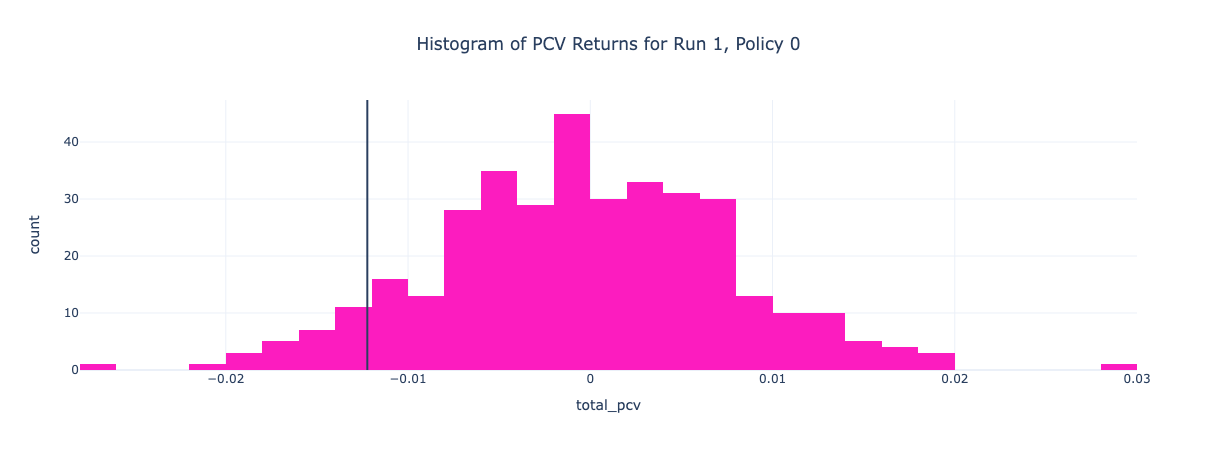

1-Day PCVar for Run 1, Policy 0 (Subset 0) is 4112061.49 USD with 5% quantile value -1.22 %
time: 101 ms (started: 2022-07-08 15:23:39 -04:00)


In [128]:
alpha = 0.95
pcv_ret = df.query('run==1 and subset==0')['total_pcv'].pct_change()
var, q = calculate_VaR_run(df, 1, alpha, 1, 0, 365)


fig = px.histogram(pcv_ret, x="total_pcv", title="Histogram of PCV Returns for Run 1, Policy 0")
fig.add_vline(x=q)

fig.show()
print('1-Day PCVar for Run 1, Policy 0 (Subset 0) is', np.round(var,2),
      'USD with 5% quantile value', 100*np.round(q, 4),'%')


PCVaR Summary Statistics across all monte carlo runs for each policy (parameter subset)

In [129]:
VAR_1_stats

subset_1_0       VaR_1_0     q_1_0  subset_1_1       VaR_1_1     q_1_1
mean         0.0  4.558287e+06 -0.012684         1.0  3.657313e+06 -0.009880
std          0.0  3.466965e+05  0.002007         0.0  2.256864e+05  0.001058
min          0.0  4.147022e+06 -0.015664         1.0  3.383477e+06 -0.011449
25%          0.0  4.332894e+06 -0.014528         1.0  3.531391e+06 -0.010579
50%          0.0  4.426360e+06 -0.011894         1.0  3.570583e+06 -0.009866
75%          0.0  4.705887e+06 -0.011460         1.0  3.816863e+06 -0.009123
max          0.0  5.223563e+06 -0.009558         1.0  4.073601e+06 -0.008111

time: 55.7 ms (started: 2022-07-08 15:23:39 -04:00)


In [130]:
print(f"1-day average PCV at Risk at 95th quantile for subset 0: \n {np.round(VAR_1_stats['VaR_1_0'].loc['mean'], 2):,} USD")

1-day average PCV at Risk at 95th quantile for subset 0: 
 4,558,287.34 USD
time: 32 ms (started: 2022-07-08 15:23:39 -04:00)


In [131]:
print(f"1-day average PCV at Risk at 95th quantile for subset 1: \n {np.round(VAR_1_stats['VaR_1_1'].loc['mean'], 2):,} USD")

1-day average PCV at Risk at 95th quantile for subset 1: 
 3,657,313.36 USD
time: 31.7 ms (started: 2022-07-08 15:23:39 -04:00)


### Empirical Probability of KPI at Threshold analyisis

In [33]:
def calculate_VaR_threshold_probability(df, n_timesteps, threshold):
    L = []
    colnames = []
    for subset in df['subset'+'_'+str(n_timesteps)].value_counts().index:
        df_ = (df.query('subset'+'_'+str(n_timesteps)+'==@subset')['q_'+str(n_timesteps)] <= threshold).astype(int)
        emp_probability = df_.sum()/len(df_)
        L.append(emp_probability)
        colnames.append('q_'+str(n_timesteps)+'_'+str(subset))
    return dict(zip(colnames,L))

time: 32.1 ms (started: 2022-07-08 14:17:14 -04:00)


In [35]:
# check for how many simulation runs PCV at Risk is < 1% of total PCV
quantile_return_threshold = -1e-2
q_probabilities = calculate_VaR_threshold_probability(VAR_df_dict[1], 1, quantile_return_threshold)

time: 116 ms (started: 2022-07-08 14:27:43 -04:00)


In [36]:
print('For Policy 1, the 1-Day PCV at risk is less than 1% with a', 100*q_probabilities['q_1_0'],'% probability')
print('For Policy 2, the 1-Day PCV at risk is less than 1% with a', 100*q_probabilities['q_1_1'],'% probability')

For Policy 1, the 1-Day PCV at risk is less than 1% with a 90.0 % probability
For Policy 2, the 1-Day PCV at risk is less than 1% with a 50.0 % probability
time: 30.7 ms (started: 2022-07-08 14:27:43 -04:00)


From this analysis, we see that over the 10 monte carlo runs for each policy (each subset), since the probability of PCV at risk being less than 1% of total PCV on any given day is lower for policy 1 than for policy 2, policy 1 does a better job at risk mitigation, hence we recommend policy 1.

### Comparative Average KPI analysis

In [37]:
avg_VaR_delta = np.round(VAR_1_stats['VaR_1_0'].loc['mean'], 2) - np.round(VAR_1_stats['VaR_1_1'].loc['mean'], 2)

time: 34.4 ms (started: 2022-07-08 14:27:44 -04:00)


In [38]:
avg_VaR_quantile_delta = np.round(VAR_1_stats['q_1_0'].loc['mean'] - VAR_1_stats['q_1_1'].loc['mean'], 4)

time: 42 ms (started: 2022-07-08 14:27:45 -04:00)


In [39]:
print(f"The Average PCVaR Delta between parameter for policies 1 and 2 is: \n {avg_VaR_delta:,} USD")

The Average PCVaR Delta between parameter for policies 1 and 2 is: 
 900,973.98 USD
time: 32.5 ms (started: 2022-07-08 14:27:45 -04:00)


In [40]:
print(f"The Average PCVaR Quantile Delta between parameter for policies 1 and 2 is: \n {avg_VaR_quantile_delta:,}")

The Average PCVaR Quantile Delta between parameter for policies 1 and 2 is: 
 -0.0028
time: 30.7 ms (started: 2022-07-08 14:27:46 -04:00)


We conclude that while the 1-Day PCVaR is greater for policy 1 than for policy 2, meaning more PCV is at risk on any given day at a 95% quantile, the value of this quantile is lower, meaning the PCV has a lower magnitude of negative returns, attesting to the risk mitigating effect of policy 1. Hence, policy 1 is recommended.

## 10-day PCV at Risk

In [41]:
VAR_10_stats

subset_10_0      VaR_10_0    q_10_0  subset_10_1      VaR_10_1    q_10_1
mean          0.0  1.441457e+07 -0.012684          1.0  1.156544e+07 -0.009880
std           0.0  1.096351e+06  0.002007          0.0  7.136830e+05  0.001058
min           0.0  1.311403e+07 -0.015664          1.0  1.069950e+07 -0.011449
25%           0.0  1.370182e+07 -0.014528          1.0  1.116724e+07 -0.010579
50%           0.0  1.399738e+07 -0.011894          1.0  1.129117e+07 -0.009866
75%           0.0  1.488132e+07 -0.011460          1.0  1.206998e+07 -0.009123
max           0.0  1.651836e+07 -0.009558          1.0  1.288186e+07 -0.008111

time: 44.3 ms (started: 2022-07-08 14:27:46 -04:00)


In [42]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 0,',
#       np.round(VAR_10_stats['VaR_10_0'].loc['mean'], 2), 'USD is the mean 10-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_10_stats['q_10_0'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 29.5 ms (started: 2022-07-08 14:27:47 -04:00)


In [43]:
# print('Over the simulation, for parameters in the sweep corresponding to subset 1,',
#       np.round(VAR_10_stats['VaR_10_1'].loc['mean'], 2), 'USD is the mean 10-Day PCVaR at 95% over the 20 runs performed, with associated',
#       np.round(VAR_10_stats['q_10_1'].loc['mean'], 4), '% average 5% quantile percentile loss')

time: 30.3 ms (started: 2022-07-08 14:27:47 -04:00)


In [44]:
print(f"10-day PCV at Risk at 95th quantile for subset 0: \n {np.round(VAR_10_stats['VaR_10_0'].loc['mean'], 2):,} USD")

10-day PCV at Risk at 95th quantile for subset 0: 
 14,414,570.21 USD
time: 31.3 ms (started: 2022-07-08 14:27:47 -04:00)


In [45]:
print(f"10-day PCV at Risk at 95th quantile for subset 1: \n {np.round(VAR_10_stats['VaR_10_1'].loc['mean'], 2):,} USD")

10-day PCV at Risk at 95th quantile for subset 1: 
 11,565,440.32 USD
time: 46.3 ms (started: 2022-07-08 14:27:48 -04:00)


## Summary Statistics

In [46]:
_df = df.groupby(['subset','timestep']).mean().query('subset == 0')
stats_df = _df.describe()
stats_df.loc['skew'] = _df.skew()
stats_df.loc['kurtosis'] = _df.kurtosis()
# TODO: max drawdown & other relevant summary stats here

stats_df

total_fei_supply  total_protocol_owned_fei  \
count         3.650000e+02              3.650000e+02   
mean          4.495885e+08              2.035454e+08   
std           2.145404e+05              9.454221e+06   
min           4.489638e+08              1.954638e+08   
25%           4.494778e+08              1.960305e+08   
50%           4.496264e+08              1.973971e+08   
75%           4.497180e+08              2.110778e+08   
max           4.500026e+08              2.250000e+08   
skew         -8.288502e-01              8.669813e-01   
kurtosis      6.963336e-01             -7.339239e-01   

          total_user_circulating_fei  idle_user_circulating_fei  \
count                   3.650000e+02                      365.0   
mean                    2.460432e+08                225000000.0   
std                     9.310525e+06                        0.0   
min                     2.250000e+08                225000000.0   
25%                     2.386500e+08                225000000.0   
50%                     2.523000e+08                225000000.0   
75%                     2.535000e+08                225000000.0   
max                     2.535000e+08                225000000.0   
skew                   -8.692639e-01                        0.0   
kurtosis               -7.314980e-01                        0.0   

          fei_minted_redeemed  cumulative_psm_redemptions  fei_price  \
count              365.000000                       365.0      365.0   
mean             -2786.248460                         0.0        1.0   
std              38339.428507                         0.0        0.0   
min            -125295.946028                         0.0        1.0   
25%             -30348.447020                         0.0        1.0   
50%              -2791.581346                         0.0        1.0   
75%              23437.314883                         0.0        1.0   
max              91386.983330                         0.0        1.0   
skew                -0.029720                         0.0        0.0   
kurtosis            -0.282137                         0.0        0.0   

          volatile_asset_price  stable_asset_price  liquidity_pool_invariant  \
count               365.000000          365.000000              3.650000e+02   
mean               1941.159748            0.999919              3.132048e+11   
std                  29.995302            0.001506              4.145436e+08   
min                1854.483962            0.995011              3.125054e+11   
25%                1925.564396            0.998975              3.128442e+11   
50%                1947.865400            0.999923              3.131951e+11   
75%                1960.358194            1.000828              3.135628e+11   
max                2000.488432            1.004883              3.139343e+11   
skew                 -0.828259            0.105769              4.722865e-02   
kurtosis              0.644610            0.267246             -1.213651e+00   

          ...  volatile_deposit_yield_bearing_balance  \
count     ...                                   365.0   
mean      ...                                 51250.0   
std       ...                                     0.0   
min       ...                                 51250.0   
25%       ...                                 51250.0   
50%       ...                                 51250.0   
75%       ...                                 51250.0   
max       ...                                 51250.0   
skew      ...                                     0.0   
kurtosis  ...                                     0.0   

          volatile_deposit_yield_bearing_asset_value  \
count                                          365.0   
mean                                     102500000.0   
std                                              0.0   
min                                      102500000.0   
25%                                      102500000.0   
50%              

time: 262 ms (started: 2022-07-08 14:27:48 -04:00)


# Analysis 4: Capital Allocation Metrics

In [47]:
fei_capital_allocation_variables = [
    'fei_deposit_idle_balance',
    'fei_deposit_liquidity_pool_balance',
    'fei_deposit_money_market_balance'
]
fei_capital_allocation_variables.sort()

time: 30.1 ms (started: 2022-07-08 14:27:49 -04:00)


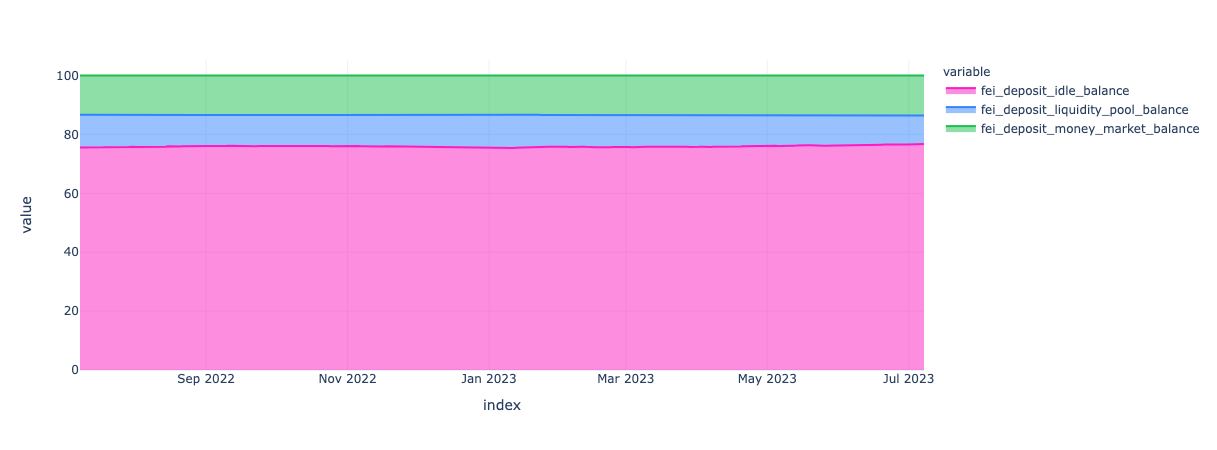

time: 216 ms (started: 2022-07-08 14:27:49 -04:00)


In [48]:
import plotly.express as px

px.area(df_2.sort_index(), y=fei_capital_allocation_variables, groupnorm='percent')

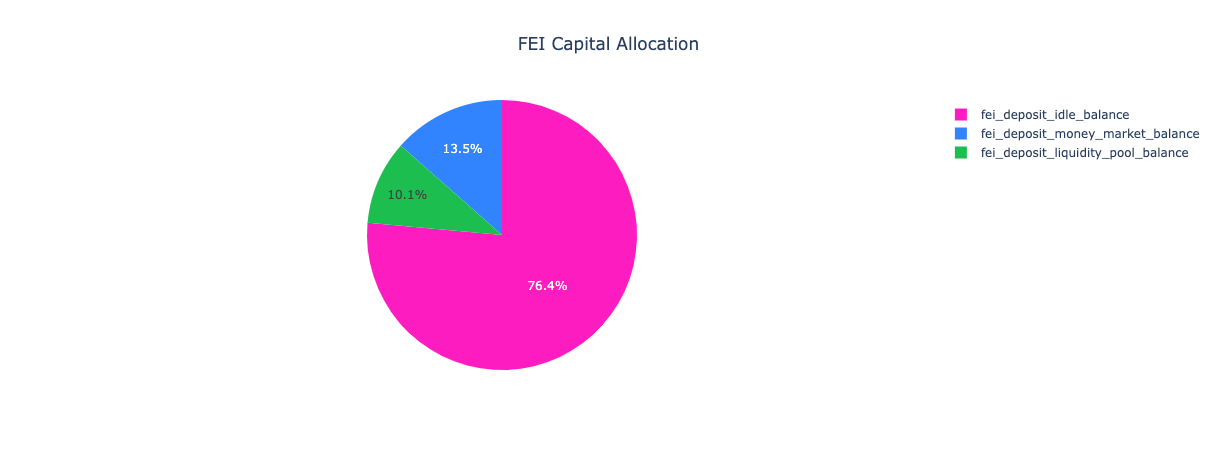

time: 76.4 ms (started: 2022-07-08 14:27:49 -04:00)


In [49]:
df_allocations = df[fei_capital_allocation_variables].iloc[-1]

px.pie(df_allocations.sort_index(), title='FEI Capital Allocation', values=df_allocations.values, names=df_allocations.index)

# Assorted Metrics

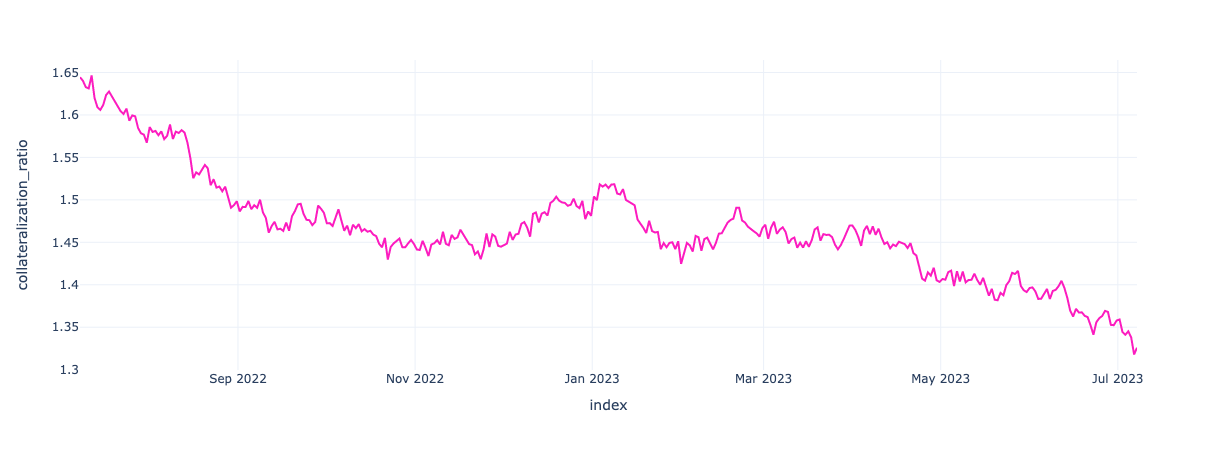

time: 93.4 ms (started: 2022-07-08 14:27:50 -04:00)


In [50]:
df_2.plot(y="collateralization_ratio")

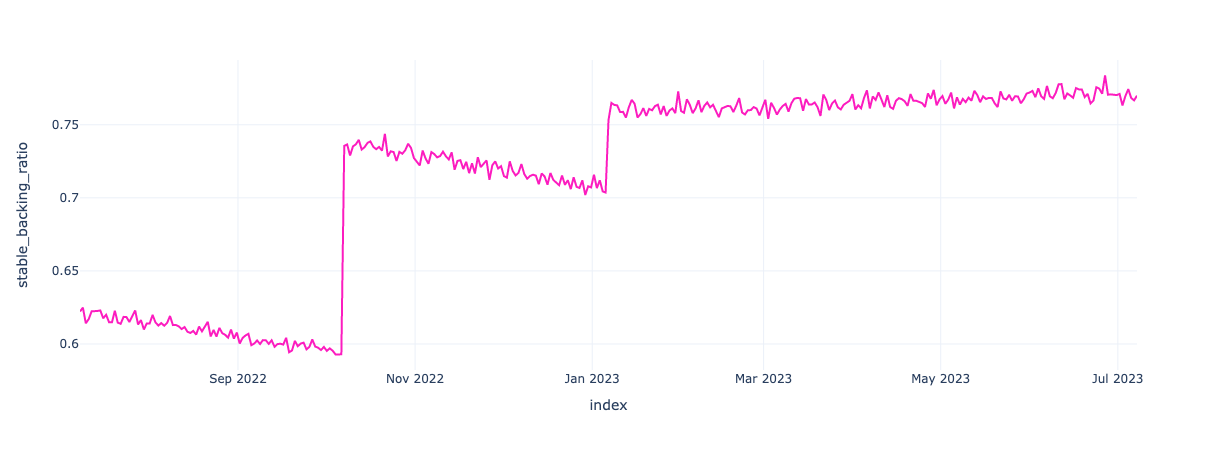

time: 93.1 ms (started: 2022-07-08 14:27:51 -04:00)


In [51]:
df_2.plot(y="stable_backing_ratio")

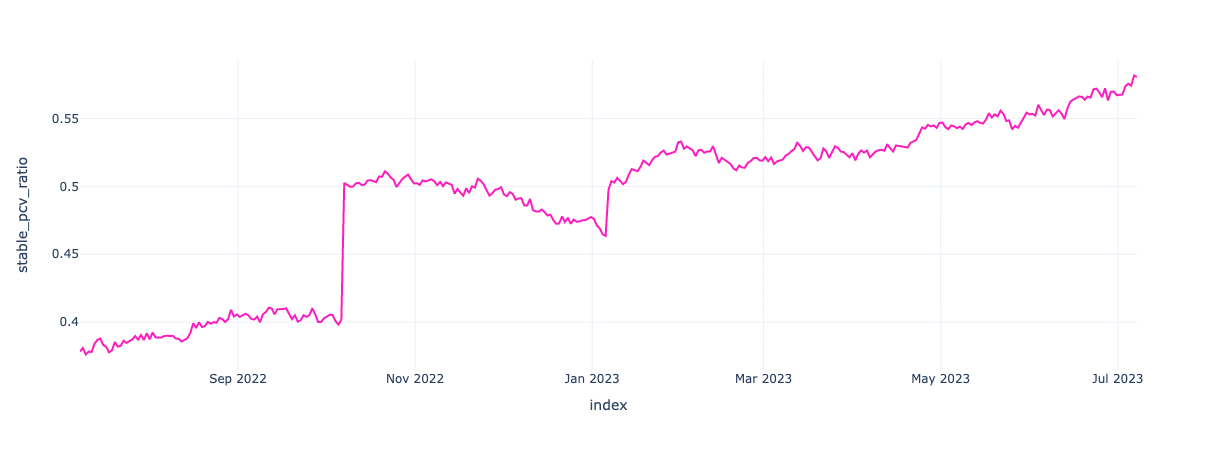

time: 92.8 ms (started: 2022-07-08 14:27:51 -04:00)


In [52]:
df_2.plot(y="stable_pcv_ratio")

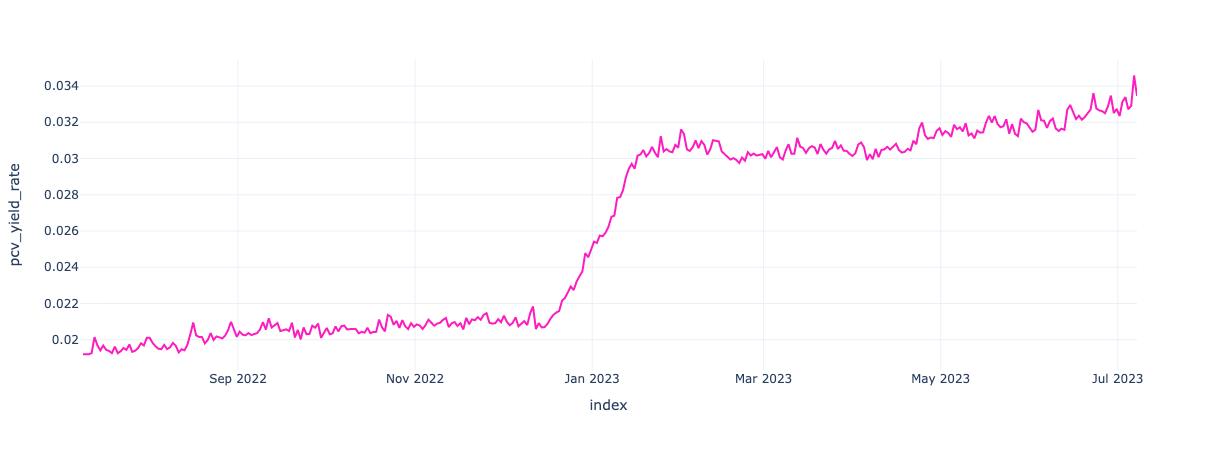

time: 96.3 ms (started: 2022-07-08 14:27:51 -04:00)


In [53]:
df_2.plot(y="pcv_yield_rate")

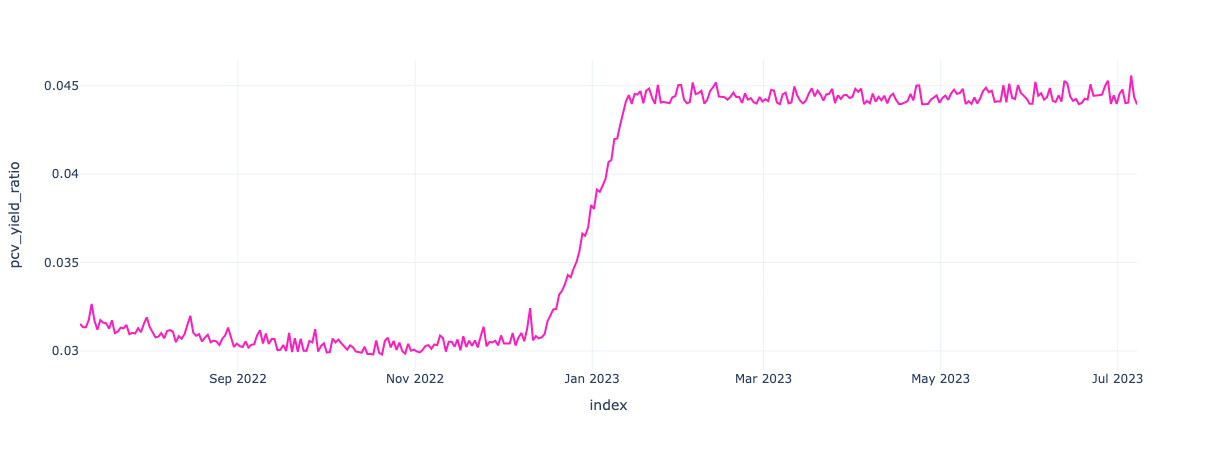

time: 98.3 ms (started: 2022-07-08 14:27:51 -04:00)


In [54]:
df_2["pcv_yield_ratio"] = df_2["pcv_yield"] / df_2["total_user_circulating_fei"] * 365 / df_2["dt"]

df_2.plot(y="pcv_yield_ratio")